In [1]:
#in_the_name_of GOD

In [2]:
from datetime import datetime
import time
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import re
from IPython.display import clear_output

#ploting
pd.set_option('display.max_columns', 500) # number of columns to be displayed
pd.set_option('display.width', 1500)      # max table width to display
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import matplotlib.cm as cm
import seaborn as sns
sns.set(rc={'figure.figsize':(15, 5)})
def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color


# import pytz module for working with time zone
import pytz
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")


In [48]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

account=5330047
authorized=mt5.login(account) 

if authorized:    
    account_info=mt5.account_info()
    terminal_info=mt5.terminal_info()
    

    # create 'datetime' objects in UTC time zone to avoid the implementation of a local time zone offset
    utc_from = datetime(2009, 10, 1, 0, 0, 0, 0, tzinfo=timezone)
    utc_to   = datetime.today()
    rates_D  = pd.DataFrame(mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_D1, utc_from, utc_to))
    rates_MN  = pd.DataFrame(mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_MN1, utc_from, utc_to))
    

# shut down connection to the MetaTrader 5 terminal
mt5.shutdown()

True

In [49]:
#fix time type from time_msc to date time
rates_MN.time=rates_MN.time.apply(lambda x : time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)) )
rates_D.time  =rates_D.time.apply(lambda x : time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)) )

In [50]:
rates_MN.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2009-10-01 03:30:00,1.46367,1.50617,1.44835,1.47185,1171349,8,0
1,2009-11-01 03:30:00,1.47346,1.51437,1.46262,1.50075,1150472,8,0
2,2009-12-01 03:30:00,1.50074,1.51399,1.42175,1.43306,971268,8,0
3,2010-01-01 03:30:00,1.43259,1.45785,1.38610,1.38611,948949,8,0
4,2010-02-01 03:30:00,1.38627,1.40255,1.34433,1.36310,943750,8,0


In [51]:
rates_D.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,2009-10-01 03:30:00,1.46367,1.46676,1.45170,1.45423,54665,9,0
1,2009-10-02 03:30:00,1.45416,1.46457,1.44835,1.45740,50781,9,0
2,2009-10-05 03:30:00,1.45883,1.46676,1.45791,1.46474,47918,9,0
3,2009-10-06 03:30:00,1.46476,1.47609,1.46445,1.47207,52419,20,0
4,2009-10-07 03:30:00,1.47208,1.47355,1.46489,1.46862,49690,9,0


In [118]:
df=rates_D.copy()

for i in range(2,df.shape[0]-1):
    current = df.iloc[i]
    prev = df.iloc[i-1]
    prev_2 = df.iloc[i-2]
    realbody = abs(current['open'] - current['close'])
    candle_range = current['high'] - current['low']
    
    idx = df.index[i]
    
    # https://www.tradingview.com/support/solutions/43000521824-pivot-points-standard/
    # traditianal pivot
    #pp=(prev['high'] + prev['low']+prev['close'])/3 
    #df.loc[idx,'PP'] = pp
    #df.loc[idx,'R1'] = 2*pp - prev['low'] 
    #df.loc[idx,'S1'] = 2*pp - prev['high']
    #df.loc[idx,'R2'] = pp + (prev['high'] - prev['low'] )
    #df.loc[idx,'S2'] = pp - (prev['high'] - prev['low'] )
    
    #df.loc[idx,'R3'] = pp + 2*(prev['high'] - prev['low'] )
    #df.loc[idx,'S3'] = pp - 2*(prev['high'] - prev['low'] )


    #label
    next_bar = df.iloc[i+1]
    df.loc[idx,'label'] = current['close'] < next_bar['close'] 
    
    # Bullish swing
    df.loc[idx,'Bullish swing'] = current['low'] > prev['low'] and prev['low'] < prev_2['low']

    # Bearish swing
    df.loc[idx,'Bearish swing'] = current['high'] < prev['high'] and prev['high'] > prev_2['high']

    # Bullish pinbar
    df.loc[idx,'Bullish pinbar'] = realbody <= candle_range/3 and  min(current['open'], current['close']) > (current['high'] + current['low'])/2 and current['low'] < prev['low']

    # Bearish pinbar
    df.loc[idx,'Bearish pinbar'] = realbody <= candle_range/3 and max(current['open'] , current['close']) < (current['high'] + current['low'])/2 and current['high'] > prev['high']

    # Inside bar
    df.loc[idx,'Inside bar'] = current['high'] < prev['high'] and current['low'] > prev['low']

    # Outside bar
    df.loc[idx,'Outside bar'] = current['high'] > prev['high'] and current['low'] < prev['low']

    # Bullish engulfing
    df.loc[idx,'Bullish engulfing'] = current['high'] > prev['high'] and current['low'] < prev['low'] and realbody >= 0.8 * candle_range and current['close'] > current['open']

    # Bearish engulfing
    df.loc[idx,'Bearish engulfing'] = current['high'] > prev['high'] and current['low'] < prev['low'] and realbody >= 0.8 * candle_range and current['close'] < current['open']

df=df.dropna()

In [122]:
cc=df.set_index('time')
cc.head()
x=[ 'label','PP','R1','R2','R3','S1','S2','S3','spread' ,'tick_volume','Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing', 'Bearish engulfing']


,open,high,low,close,tick_volume,spread,real_volume,label,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing
time,,,,,,,,,,,,,,,,
2009-10-05 03:30:00,1.45883,1.46676,1.45791,1.46474,47918,9,0,True,True,False,False,False,False,False,False,False
2009-10-06 03:30:00,1.46476,1.47609,1.46445,1.47207,52419,20,0,False,False,False,False,False,False,False,False,False
2009-10-07 03:30:00,1.47208,1.47355,1.46489,1.46862,49690,9,0,True,False,True,False,False,True,False,False,False
2009-10-08 03:30:00,1.46863,1.48150,1.46816,1.47905,52747,9,0,False,False,False,False,False,False,False,False,False
2009-10-09 03:30:00,1.47903,1.47933,1.46723,1.47300,51998,9,0,True,False,True,False,False,False,False,False,False


In [127]:
cd=df.set_index('time')
x=[ 'label','PP','R1','R2','R3','S1','S2','S3','spread' ,'tick_volume','Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing', 'Bearish engulfing']
cdRaw=cd[x]
cdRaw.head()

KeyError: "['S1', 'R1', 'R3', 'PP', 'R2', 'S2', 'S3'] not in index"

In [124]:
merge=pd.merge(cc,cd, how='inner', left_index=True, right_index=True)
merge

,open_x,high_x,low_x,close_x,tick_volume_x,spread_x,real_volume_x,label_x,Bullish swing_x,Bearish swing_x,Bullish pinbar_x,Bearish pinbar_x,Inside bar_x,Outside bar_x,Bullish engulfing_x,Bearish engulfing_x,open_y,high_y,low_y,close_y,tick_volume_y,spread_y,real_volume_y,PP,R1,S1,R2,S2,R3,S3,label_y,Bullish swing_y,Bearish swing_y,Bullish pinbar_y,Bearish pinbar_y,Inside bar_y,Outside bar_y,Bullish engulfing_y,Bearish engulfing_y
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-01 03:30:00,1.50074,1.51164,1.49712,1.50761,49804,10,0,False,False,False,False,False,False,False,False,False,1.50074,1.51399,1.42175,1.43306,971268,8,0,1.492580,1.522540,1.470790,1.544330,1.440830,1.596080,1.389080,False,False,True,False,False,False,False,False,False
2010-02-01 03:30:00,1.38627,1.39376,1.38521,1.39325,46608,9,0,True,False,False,False,False,False,False,False,False,1.38627,1.40255,1.34433,1.36310,943750,8,0,1.410020,1.433940,1.362190,1.481770,1.338270,1.553520,1.266520,False,False,False,False,False,False,False,False,False
2010-03-01 03:30:00,1.36222,1.36541,1.34601,1.35677,47959,8,0,True,False,True,True,False,False,False,False,False,1.36222,1.38171,1.32671,1.35062,897812,8,0,1.369993,1.395657,1.337437,1.428213,1.311773,1.486433,1.253553,False,False,False,False,False,False,False,False,False
2010-04-01 04:30:00,1.35065,1.35904,1.34600,1.35837,38590,8,0,False,True,False,False,False,False,False,False,False,1.35065,1.36913,1.31141,1.32936,883127,8,0,1.353013,1.379317,1.324317,1.408013,1.298013,1.463013,1.243013,False,False,False,False,False,False,False,False,False
2010-06-01 04:30:00,1.23061,1.23487,1.21107,1.22115,66264,10,0,True,False,False,False,False,False,True,False,False,1.23061,1.24664,1.18758,1.22302,1175430,7,1237300000,1.259470,1.304590,1.185680,1.378380,1.140560,1.497290,1.021650,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01 04:30:00,1.11150,1.11536,1.11003,1.11343,61548,0,0,True,False,False,False,False,False,False,False,False,1.11150,1.14222,1.11003,1.12336,1540638,0,0,1.100633,1.124627,1.086767,1.138493,1.062773,1.176353,1.024913,True,False,False,False,False,False,False,False,False
2020-07-01 04:30:00,1.12340,1.12749,1.11847,1.12507,45694,1,0,False,False,False,True,False,False,True,False,False,1.12340,1.19086,1.11847,1.17713,1173709,0,0,1.125203,1.140377,1.108187,1.157393,1.093013,1.189583,1.060823,True,False,False,False,False,False,False,False,False
2020-09-01 04:30:00,1.19358,1.20108,1.19011,1.19113,58939,0,0,False,False,False,False,True,False,False,False,False,1.19358,1.20108,1.16122,1.17210,1109353,0,0,1.186593,1.203617,1.176587,1.213623,1.159563,1.240653,1.132533,False,False,False,False,False,False,True,False,False


In [ ]:
merge.

In [86]:
x=[ 'label','PP','R1','R2','R3','S1','S2','S3','spread' ,'tick_volume','Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing', 'Bearish engulfing']
dfRaw=df[x]
dfRaw.head()

,label,PP,R1,R2,R3,S1,S2,S3,spread,tick_volume,Bullish swing,Bearish swing,Bullish pinbar,Bearish pinbar,Inside bar,Outside bar,Bullish engulfing,Bearish engulfing
2,False,1.492580,1.522540,1.544330,1.596080,1.470790,1.440830,1.389080,8,971268,False,True,False,False,False,False,False,False
3,False,1.456267,1.490783,1.548507,1.640747,1.398543,1.364027,1.271787,8,948949,False,False,False,False,False,False,False,False
4,False,1.410020,1.433940,1.481770,1.553520,1.362190,1.338270,1.266520,8,943750,False,False,False,False,False,False,False,False
5,False,1.369993,1.395657,1.428213,1.486433,1.337437,1.311773,1.253553,8,897812,False,False,False,False,False,False,False,False
6,False,1.353013,1.379317,1.408013,1.463013,1.324317,1.298013,1.243013,8,883127,False,False,False,False,False,False,False,False


In [108]:
import six
import sys
from copy import deepcopy
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support

Start_range=3
end_range=25
NUMBER_OF_TEST_per_data=10

t1=time.time()
n,k=0,len(range(Start_range,end_range))*NUMBER_OF_TEST_per_data

data=dfRaw.drop('label',1)
label=dfRaw.label
Result=list()

for Max_depth in range(Start_range,end_range):
    estimator = Id3Estimator(max_depth=Max_depth, min_samples_split=1, prune=True,
                    gain_ratio=True, min_entropy_decrease=0, is_repeating=True)
    temp=list()
    for NT in range(NUMBER_OF_TEST_per_data):
        clear_output(wait=True)
        n=n+1
        print('Learning Process has ',round((n/k)*100,4),' % complete')
        estimator.fit(data,label , check_input=True)
        ACC=precision_recall_fscore_support(list(label), list(estimator.predict(data)),average='weighted')[0]
        temp.append((ACC,deepcopy(estimator)))
    temp_index=[(x[0],i) for i,x in enumerate(temp)]
    temp_index.sort()
    Acc=temp[temp_index[-1][1]][0]
    estimator=temp[temp_index[-1][1]][1]
    Result.append(deepcopy(estimator))

t2=time.time()
print(round((t2-t1)/60) ,'min has time for calculaton Model')

Learning Process has  100.0  % complete
1 min has time for calculaton Model


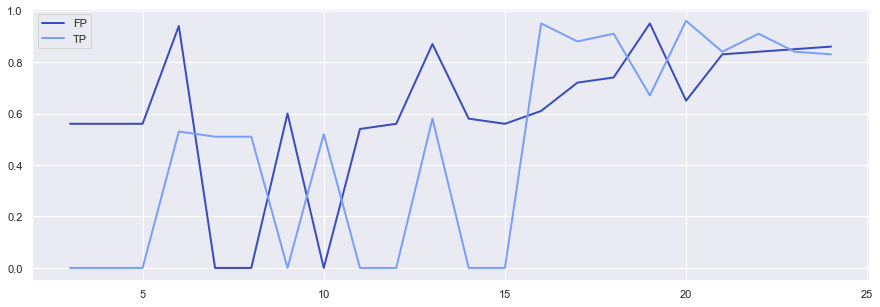

In [109]:
plot_list_FP=list()
plot_list_TP=list()
for max_depth in range(Start_range,end_range):
    es=Result[max_depth-Start_range]
    l=classification_report(list(label), list(es.predict(data)))
    plot_list_TP.append(int(re.findall("True       \d.\d+", l)[0].split('.')[1])/100)
    plot_list_FP.append(int(re.findall("False       \d.\d+", l)[0].split('.')[1])/100)
    
fig, ax = plt.subplots()
for Lambda,chart in enumerate([plot_list_FP,plot_list_TP]):
    ax.plot(range(Start_range,end_range),chart, linestyle='-', linewidth=2,c=color_map_color(Lambda*2),label=["FP","TP"][Lambda])
ax.legend();
plt.show() 

In [112]:
es=Result[7]
feature_names=['PP','R1','R2','R3','S1','S2','S3','spread' ,'tick_volume','Bullish swing', 'Bearish swing', 'Bullish pinbar', 'Bearish pinbar', 'Inside bar', 'Outside bar', 'Bullish engulfing', 'Bearish engulfing']
print(export_text(es.tree_, feature_names))


R2 <=1.54
|   R3 <=1.60
|   |   R3 <=1.54
|   |   |   Bullish engulfing <=0.50
|   |   |   |   tick_volume <=722873.00: True (2) 
|   |   |   |   tick_volume >722873.00
|   |   |   |   |   Bearish engulfing <=0.50
|   |   |   |   |   |   R1 <=1.11
|   |   |   |   |   |   |   PP <=1.06: False (1) 
|   |   |   |   |   |   |   PP >1.06: True (6) 
|   |   |   |   |   |   R1 >1.11
|   |   |   |   |   |   |   S2 <=1.36: True (40/31) 
|   |   |   |   |   |   |   S2 >1.36: True (2) 
|   |   |   |   |   Bearish engulfing >0.50: False (1) 
|   |   |   Bullish engulfing >0.50: False (2) 
|   |   R3 >1.54: False (4) 
|   R3 >1.60: True (2) 
R2 >1.54: False (2) 



In [ ]:
https://medium.com/python-in-plain-english/combining-candlestick-patterns-with-technical-indicators-a-python-study-77492ea8673

In [ ]:
https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5